<a href="https://colab.research.google.com/github/biswas-neelesh96/6TSRAM-Butterfly-Curve/blob/main/6T_Butterfly_SRAM_Curve__Hold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

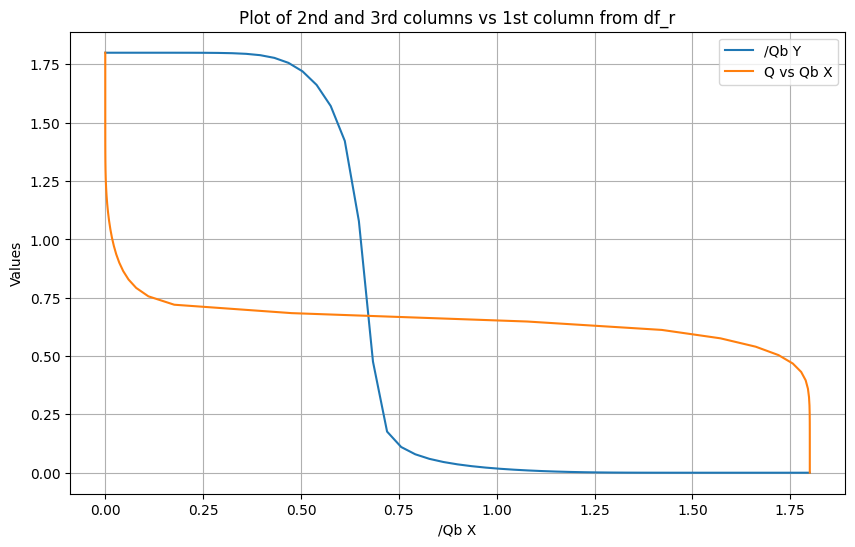

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
df_r = pd.read_csv("/content/6TSRAM_H.csv")
plt.figure(figsize=(10, 6))

plt.plot(df_r.iloc[:, 0], df_r.iloc[:, 1], label=df_r.columns[1])
plt.plot(df_r.iloc[:,2], df_r.iloc[:, 0], label=df_r.columns[2])

plt.xlabel(df_r.columns[0])
plt.ylabel('Values')
plt.title('Plot of 2nd and 3rd columns vs 1st column from df_r')
plt.legend()
plt.grid(True)
plt.show()

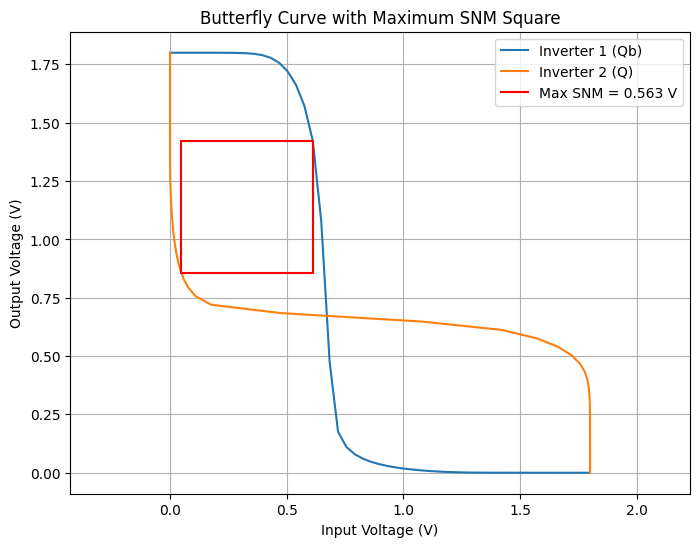

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Extract data from the DataFrame
x1 = df_r["/Qb X"].values
y1 = df_r["/Qb Y"].values
x2 = df_r["Q vs Qb Y"].values  # This is the mirrored inverter's X
y2 = df_r["Q vs Qb X"].values  # This is the mirrored inverter's Y

# Interpolation functions
f1 = interp1d(x1, y1, kind='cubic', fill_value="extrapolate")
f2 = interp1d(y2, x2, kind='cubic', fill_value="extrapolate")

# Define a range for the center of the square
# We are looking for the largest square in the open area, which is roughly in the center of the plot.
# Let's define a search range for the x and y coordinates of the center of the square.
x_center_range = np.linspace(min(x1), max(x1), 50) # Reduced points for faster iteration
y_center_range = np.linspace(min(y1), max(y1), 50) # Reduced points for faster iteration


max_side_length = 0
best_square_center = (0, 0)

# Iterate through possible centers and side lengths to find the largest square
for cx in x_center_range:
    for cy in y_center_range:
        # Use binary search to find the maximum side length for a given center (cx, cy)
        low = 0
        high = min(max(x1) - min(x1), max(y1) - min(y1)) # Maximum possible side is limited by the plot dimensions

        for _ in range(50): # Perform a fixed number of iterations for binary search
            s = (low + high) / 2
            half_s = s / 2

            # Check if the square with side 's' centered at (cx, cy) is within the bounds
            x_min, x_max = cx - half_s, cx + half_s
            y_min, y_max = cy - half_s, cy + half_s

            # Check if the square is within the x-range of the data where interpolation is valid
            if x_min < np.min(x1) or x_max > np.max(x1) or x_min < np.min(x2) or x_max > np.max(x2):
                 high = s
                 continue

            # Check if the square is within the y-range of the data where interpolation is valid
            if y_min < np.min(y1) or y_max > np.max(y1) or y_min < np.min(y2) or y_max > np.max(y2):
                 high = s
                 continue


            # More robust check: sample points along the top and bottom edges of the square
            num_check_points = 20
            check_x_points = np.linspace(x_min, x_max, num_check_points)
            top_edge_y = y_max * np.ones(num_check_points)
            bottom_edge_y = y_min * np.ones(num_check_points)

            # Check if the top edge is below f1 and the bottom edge is above f2
            top_edge_ok = np.all(top_edge_y < f1(check_x_points))
            bottom_edge_ok = np.all(bottom_edge_y > f2(check_x_points))


            if top_edge_ok and bottom_edge_ok:
                # If the square fits, try a larger one
                low = s
            else:
                # Otherwise, the square is too large
                high = s

        # After binary search, 'low' is the maximum side length for this center (cx, cy)
        if low > max_side_length:
            max_side_length = low
            best_square_center = (cx, cy)

# Coordinates of the largest square
half_side = max_side_length / 2
square_x = [best_square_center[0] - half_side, best_square_center[0] + half_side, best_square_center[0] + half_side, best_square_center[0] - half_side, best_square_center[0] - half_side]
square_y = [best_square_center[1] + half_side, best_square_center[1] + half_side, best_square_center[1] - half_side, best_square_center[1] - half_side, best_square_center[1] + half_side]


# Plot the butterfly curve and the largest square
plt.figure(figsize=(8, 6))
plt.plot(x1, y1, label="Inverter 1 (Qb)")
plt.plot(y2, x2, label="Inverter 2 (Q)")
plt.plot(square_x, square_y, 'r-', label=f'Max SNM = {max_side_length:.3f} V')
plt.title("Butterfly Curve with Maximum SNM Square")
plt.xlabel("Input Voltage (V)")
plt.ylabel("Output Voltage (V)")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()